In [177]:
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,GRU,SimpleRNN,TimeDistributed
from tensorflow import keras
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt

# viterbi

In [2]:
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /Users/mac/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/mac/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
def get_tag(data):
    tags = set([word[1] for sent in data for word in sent])
    print("tags: ",tags)
    print("tag lenght: ",len(tags))

nltk_data_universal = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
nltk_data = list(nltk.corpus.treebank.tagged_sents())
print("without universal")
print(nltk_data[0])
get_tag(nltk_data)
print("universal")
print(nltk_data_universal[0])
get_tag(nltk_data_universal)

without universal
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
tags:  {'-RRB-', 'VBN', 'JJS', '-LRB-', 'MD', 'VBD', 'RBR', 'SYM', 'WDT', '.', ',', 'VBP', 'CC', "''", '-NONE-', 'IN', ':', '#', 'PRP$', 'RB', 'WP', 'RP', 'NNP', 'PDT', 'JJR', 'WP$', 'LS', 'NN', 'POS', 'JJ', '``', '$', 'CD', 'NNS', 'UH', 'VBZ', 'WRB', 'VB', 'FW', 'RBS', 'DT', 'VBG', 'EX', 'NNPS', 'TO', 'PRP'}
tag lenght:  46
universal
[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]
tags:  {'.', 'NUM', 'DET', 'CONJ', 'ADJ', 'NOUN', 

In [326]:
class Viterbi:
    def __init__(self):
        self.data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
        self.split_data()
        self.tags = list(set([word[1] for sent in self.train_set for word in sent]))
        self.vocab = list(set([word[0] for sent in self.train_set for word in sent]))
        self.words_tag = [word for sent in self.train_set for word in sent]
        self.tag_counts = self.get_tags_count()
        self.vocab_size = len(self.vocab)
        self.tag_size = len(self.tags)
        
    def split_data(self):
        self.train_set,self.test_set = train_test_split(self.data,test_size=0.15, random_state = 42)
        return self.train_set,self.test_set

    def get_tags_count(self):
        self.tags_count = {}
        for tag in self.tags:
            self.tags_count[tag] = sum([1 for pair in self.words_tag if pair[1]==tag])
        return self.tags_count

    def get_word_tag_count(self):
        word_tag_count = {}
        for word in self.vocab:
            word_tag_count[word] = {tag: 0 for tag in self.tags}

        for pair in self.words_tag:
            word = pair[0]
            tag = pair[1]
            word_tag_count[word][tag] +=1
        return word_tag_count


    def set_emission_table(self):
        word_tag_count = self.get_word_tag_count()
        tag_counts = self.get_tags_count()
        emission = np.zeros((self.vocab_size,self.tag_size), dtype='float32')
        for i in tqdm(range(len(self.vocab))):
            word = self.vocab[i]
            for j,tag in enumerate(self.tags):
                emission[i][j] = (word_tag_count[word][tag]+1)/(tag_counts[tag]+self.vocab_size)
        self.emission_df = pd.DataFrame(emission, columns = self.tags , index= self.vocab)


    def set_transition_table(self):
        tag_size = len(self.tags)
        words_with_tag = [word for sent in self.train_set for word in sent]
        transition = np.zeros((tag_size+1,tag_size), dtype='float32')
        for i,tag1 in enumerate(self.tags):
            for j,tag2 in enumerate(self.tags):
                count_tag1 = sum([1 for pair in words_with_tag if pair[1]==tag1])
                count_tag1_tag2 = sum([1 for idx in range(len(words_with_tag)-1) if (words_with_tag[idx][1]==tag1 and words_with_tag[idx+1][1]==tag2)])
                transition[i][j] = (count_tag1_tag2+1)/(count_tag1+tag_size)

        start_tags = [sent[0][1] for sent in self.train_set]
        for k,tag2 in enumerate(self.tags):
            count_start = len(start_tags)
            count_start_tag2 = sum([1 for tag in start_tags if tag == tag2])
            transition[tag_size][k] = (count_start_tag2+1) / (count_start+tag_size)

        self.transition_df = pd.DataFrame(transition, columns = self.tags , index= self.tags+['<s>'])
        return self.transition_df

    def get_tags(self,words):
        prev_step = {tag:{'prob': 0, 'steps':[]} for tag in self.tags}
        curr_step = {tag:{'prob': 0, 'steps':[]} for tag in self.tags}
        for i in range(len(words)):
            word = words[i]
            for tag in self.tags:
                if(word in self.vocab):
                    p_emission = self.emission_df.loc[word,tag]
                else:
                    p_emission = 1 /(self.tag_counts[tag]+self.vocab_size)

                if(i == 0):
                    p_transition = self.transition_df.loc['<s>',tag]
                    curr_step[tag]['prob'] = np.log(p_emission)+np.log(p_transition)
                    curr_step[tag]['steps'] = [tag]
                else:
                    probs = []
                    for prev_tag in self.tags:
                        p_transition = self.transition_df.loc[prev_tag,tag]
                        prev_tag_prob = prev_step[prev_tag]['prob']
                        prob = np.log(p_transition)+prev_tag_prob+np.log(p_emission)
                        probs.append(prob)
                        
                    pmax = max(probs)
                    chosen_tag = self.tags[probs.index(pmax)] 
                    curr_step[tag]['prob'] = pmax
                    curr_step[tag]['steps'] = prev_step[chosen_tag]['steps'] + [tag]
            prev_step = curr_step
            curr_step = {tag:{'prob': 0, 'steps':[]} for tag in self.tags}
            
     
        pmax = None
        for tag in self.tags:
            if(pmax == None):
                pmax = prev_step[tag]['prob']
                steps = prev_step[tag]['steps']
            elif(pmax < prev_step[tag]['prob']):
                pmax = prev_step[tag]['prob']
                steps = prev_step[tag]['steps']
    
        return list(zip(words, steps))

    def eval_model(self):
        corr_ans = 0 
        total = 0
        self.set_transition_table()
        self.set_emission_table()
        for i in tqdm(range(len(self.test_set))):
            sent = self.test_set[i]
            sent_word = [pair[0] for pair in sent]
            y_real = [pair[1] for pair in sent]
            y_pred = [pair[1] for pair in self.get_tags(sent_word)]
            corr_ans += sum([1 for i, j in zip(y_pred,y_real) if i == j])
            total += len(sent)
        accuracy = corr_ans/total
        print("accuracy: ",accuracy)
    
    def print_wrong_tags(self,num):
        test = self.test_set[:num]
        for i in range(len(test)):
            sent = test[i]
            sent_word = [pair[0] for pair in sent]
            real = [pair[1] for pair in sent]
            pred = [pair[1] for pair in self.get_tags(sent_word)]
            wrong_real = [real[i] for i in range(len(real)) if real[i]!=pred[i]]
            wrong_pred = [pred[i] for i in range(len(real)) if real[i]!=pred[i]]
            wrong_word = [sent_word[i] for i in range(len(real)) if real[i]!=pred[i]]
            if(real!=pred):
                print('sent',' '.join(sent_word))
                print('w_word',wrong_word)
                print('w_real',wrong_real)
                print('w_pred',wrong_pred)
                print('-----------------------------------------------')


In [327]:
viterbi = Viterbi()

In [328]:
viterbi.eval_model()

100%|██████████| 588/588 [01:19<00:00,  7.41it/s]

accuracy:  0.9002201502201502


In [329]:
viterbi.print_wrong_tags(10)

sent For the Agency for International Development , appropriators approved $ 200 million *U* in secondary loan guarantees under an expanded trade credit insurance program , and total loan guarantees for the Overseas Private Investment Corp. are increased *-3 by $ 40 million *U* over fiscal 1989 as part of the same Poland package .
w_word ['appropriators', 'expanded', 'Overseas', 'Private', '1989']
w_real ['NOUN', 'VERB', 'NOUN', 'NOUN', 'NUM']
w_pred ['PRON', 'ADJ', 'ADJ', 'ADJ', 'NOUN']
-----------------------------------------------
sent The market is just becoming more efficient . ''
w_word ['more', 'efficient']
w_real ['ADV', 'ADJ']
w_pred ['ADJ', 'NOUN']
-----------------------------------------------
sent Moscow has settled pre-1917 debts with other countries in recent years at less than face value .
w_word ['pre-1917']
w_real ['ADJ']
w_pred ['DET']
-----------------------------------------------
sent `` Unemployment continues at a relatively low level , * providing a sense of jo

## Preprocess

In [384]:
class DataLoader:

    def encode_data(self):
        dataset = nltk.corpus.treebank.tagged_sents(tagset='universal')
        train_set, test_set = train_test_split(dataset, test_size=0.15, random_state=42)
        train_set, valid_set = train_test_split(train_set, test_size=0.15, random_state=42)
        self.x_train = []
        self.y_train = []
        self.x_test = []
        self.y_test = []
        self.x_valid = []
        self.y_valid = []
        
        for sent in train_set:
            words = [pair[0] for pair in sent]
            tags = [pair[1] for pair in sent]
            self.x_train.append(words)
            self.y_train.append(tags)
            
        for sent in test_set:
            words = [pair[0] for pair in sent]
            tags = [pair[1] for pair in sent]
            self.x_test.append(words)
            self.y_test.append(tags)
            
        for sent in valid_set:
            words = [pair[0] for pair in sent]
            tags = [pair[1] for pair in sent]
            self.x_valid.append(words)
            self.y_valid.append(tags)

        self.word_tokenizer = Tokenizer(num_words=10000,oov_token="[UNK]")           
        self.word_tokenizer.fit_on_texts(self.x_train)         
        x_train_encoded = self.word_tokenizer.texts_to_sequences(self.x_train) 
        x_test_encoded = self.word_tokenizer.texts_to_sequences(self.x_test) 
        x_valid_encoded = self.word_tokenizer.texts_to_sequences(self.x_valid) 

        self.tag_tokenizer = Tokenizer()
        self.tag_tokenizer.fit_on_texts(self.y_train)
        y_train_encoded = self.tag_tokenizer.texts_to_sequences(self.y_train)
        y_test_encoded = self.tag_tokenizer.texts_to_sequences(self.y_test)
        y_valid_encoded = self.tag_tokenizer.texts_to_sequences(self.y_valid)
        return x_train_encoded,x_test_encoded,x_valid_encoded,y_train_encoded,y_test_encoded,y_valid_encoded

    def apply_padding(self,x_train_encoded,x_test_encoded,x_valid_encoded,y_train_encoded,y_test_encoded,y_valid_encoded,max_len):
        x_train_padded = pad_sequences(x_train_encoded, maxlen=max_len, padding='post')
        x_test_padded = pad_sequences(x_test_encoded, maxlen=max_len, padding='post')
        x_valid_padded = pad_sequences(x_valid_encoded, maxlen=max_len, padding='post')
        y_train_padded = pad_sequences(y_train_encoded, maxlen=max_len, padding='post')
        y_test_padded = pad_sequences(y_test_encoded, maxlen=max_len, padding='post')
        y_valid_padded = pad_sequences(y_valid_encoded, maxlen=max_len, padding='post')
        return x_train_padded,x_test_padded,x_valid_padded,y_train_padded,y_test_padded,y_valid_padded
  
    def get_vocab_size(self):
        return len(self.word_tokenizer.word_index) + 1

    def get_model_data(self,max_len):
        x_train_encoded,x_test_encoded,x_valid_encoded,y_train_encoded,y_test_encoded,y_valid_encoded = self.encode_data()
        x_train_padded,x_test_padded,x_valid_padded,y_train_padded,y_test_padded,y_valid_padded = self.apply_padding(x_train_encoded,x_test_encoded,x_valid_encoded,y_train_encoded,y_test_encoded,y_valid_encoded,max_len)
        
        return x_train_padded,x_test_padded,x_valid_padded,to_categorical(y_train_padded),to_categorical(y_test_padded),to_categorical(y_valid_padded)

In [388]:
class PosTagger:

    def __init__(self,model_name,max_seq_len = 100,embedding_size = 150):
        self.model_name = model_name
        self.dataLoader = DataLoader()
        self.X_train, self.X_test, self.X_validation, self.Y_train, self.Y_test, self.Y_validation = self.dataLoader.get_model_data(max_seq_len)
        self.vocab_size = self.dataLoader.get_vocab_size()
        self.embedding_size = embedding_size
        self.max_seq_len = max_seq_len
        self.num_class = self.Y_train.shape[2]
 
    def ignore_class_accuracy(self,to_ignore=0):
        def ignore_accuracy(y_true, y_pred):
            y_true_class = K.argmax(y_true, axis=-1)
            y_pred_class = K.argmax(y_pred, axis=-1)
 
            ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
            matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
            accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
            return accuracy
        return ignore_accuracy

    def create_model(self,units=128,batch_len=64,model_sum = False,verbose = 0):
        
        if(self.model_name == 'RNN'):
              layer = SimpleRNN(units=units,return_sequences=True )
        if(self.model_name == 'LSTM'):
              layer = LSTM(units=units,return_sequences=True )
        if(self.model_name == 'GRU'):
              layer = GRU(units=units,return_sequences=True )
        
        model = Sequential([
            Embedding(input_dim=10000, output_dim=self.embedding_size, input_length=self.max_seq_len),
            layer,
            TimeDistributed(Dense(self.num_class,activation='softmax'))
        ])

        model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics =[self.ignore_class_accuracy(0)])

        if(model_sum):
            print(model.summary())

        model_training = model.fit(self.X_train, self.Y_train, batch_size=batch_len, epochs=10, validation_data=(self.X_validation, self.Y_validation),verbose= verbose)
        
        return model,model_training.history['val_ignore_accuracy'],model_training.history['ignore_accuracy']

    
    def search_best_model(self,parameters):
        max_val_acc = None
        best_params = {}
        for pair in parameters:
            units_num = pair[0]
            batch_size = pair[1]
            print(f'#units: {units_num}')
            print(f'#batch_size: {batch_size}')
            model,val_acc , acc = self.create_model(units=units_num,batch_len = batch_size)
            print(f'#val_acc: {val_acc[-1]}')
            plt.plot(np.arange(1,len(val_acc)+1), val_acc, label='validation')
            plt.plot(np.arange(1,len(val_acc)+1), acc, label='train')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.legend()
            plt.show()
            if(max_val_acc == None):
                max_val_acc = max(val_acc)
                best_params['unit'] = units_num
                best_params['batch_size'] = batch_size
            elif(max(val_acc) > max_val_acc):
                max_val_acc = max(val_acc)
                best_params['unit'] = units_num
                best_params['batch_size'] = batch_size
        print(f'best params: {best_params}')
        
    def eval_model(self,model):
        loss, accuracy = model.evaluate(self.X_test, self.Y_test)
        print(f'#accuracy: {accuracy}')

In [356]:
units = [16,32,64]
batch_sizes = [64,128]
params = [(unit,batch) for unit in units for batch in batch_sizes]

## RNN

#units: 16
#batch_size: 64
#val_acc: 0.9152201414108276


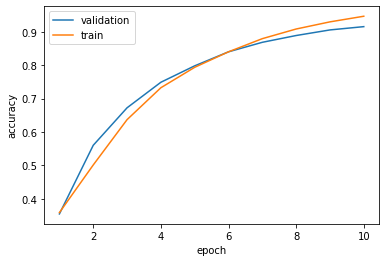

#units: 16
#batch_size: 128
#val_acc: 0.8422133922576904


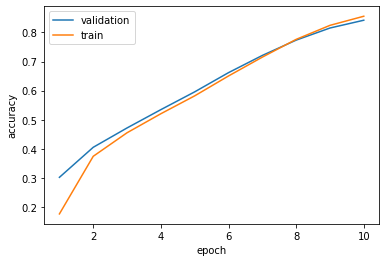

#units: 32
#batch_size: 64
#val_acc: 0.9373093843460083


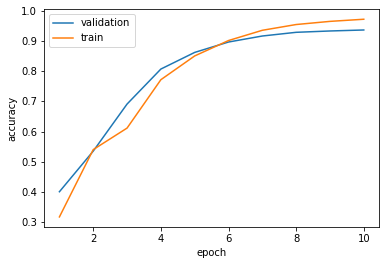

#units: 32
#batch_size: 128
#val_acc: 0.8533871173858643


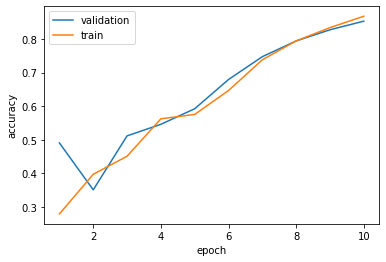

#units: 64
#batch_size: 64
#val_acc: 0.9420745372772217


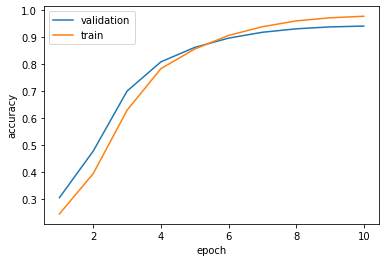

#units: 64
#batch_size: 128
#val_acc: 0.8346985578536987


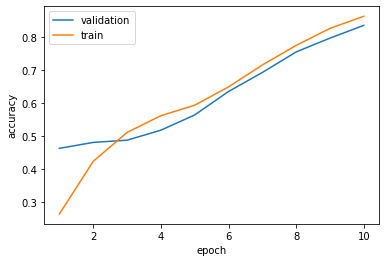

best params: {'unit': 64, 'batch_size': 64}


In [391]:
pos_tagger = PosTagger('RNN')
pos_tagger.search_best_model(params)

In [392]:
pos_tagger = PosTagger('RNN')
model,_,_ = pos_tagger.create_model(units = 64,batch_len=64, model_sum = True,verbose=1)
pos_tagger.eval_model(model)

Model: "sequential_246"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_245 (Embedding)   (None, 100, 150)          1500000   
                                                                 
 simple_rnn_136 (SimpleRNN)  (None, 100, 64)           13760     
                                                                 
 time_distributed_245 (TimeD  (None, 100, 13)          845       
 istributed)                                                     
                                                                 
Total params: 1,514,605
Trainable params: 1,514,605
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
45/45 [==============================] - 4s 74ms/step - loss: 1.0377 - ignore_accuracy: 0.2631 - val_loss: 0.6521 - val_ignore_accuracy: 0.3694
Epoch 2/10
45/45 [==============================] - 4s 80ms/step - loss: 0.5625 

## LSTM

#units: 16
#batch_size: 64
#val_acc: 0.8605361580848694


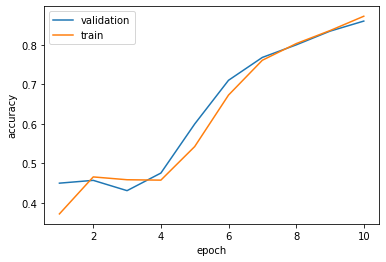

#units: 16
#batch_size: 128
#val_acc: 0.6090563535690308


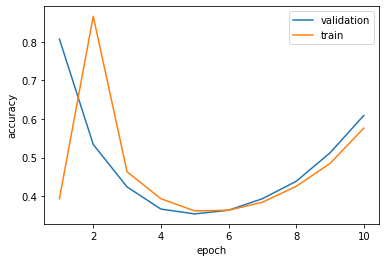

#units: 32
#batch_size: 64
#val_acc: 0.8997619152069092


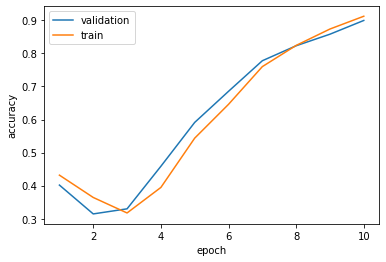

#units: 32
#batch_size: 128
#val_acc: 0.5492111444473267


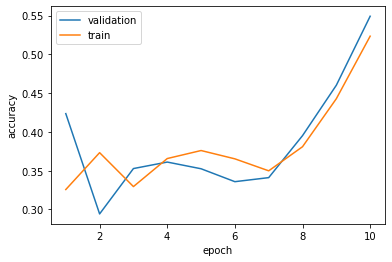

#units: 64
#batch_size: 64
#val_acc: 0.9268031120300293


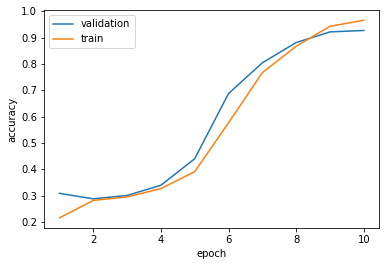

#units: 64
#batch_size: 128
#val_acc: 0.5189715027809143


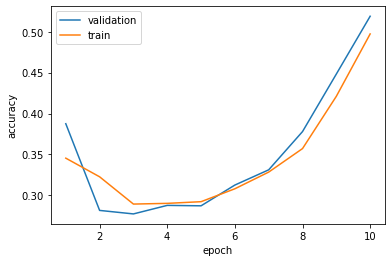

best params: {'unit': 64, 'batch_size': 64}


In [395]:
pos_tagger = PosTagger('LSTM')
pos_tagger.search_best_model(params)

In [396]:
pos_tagger = PosTagger('LSTM')
model,_,_ = pos_tagger.create_model(units = 64,batch_len=64, model_sum = True,verbose=1)
pos_tagger.eval_model(model)

Model: "sequential_260"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_259 (Embedding)   (None, 100, 150)          1500000   
                                                                 
 lstm_76 (LSTM)              (None, 100, 64)           55040     
                                                                 
 time_distributed_259 (TimeD  (None, 100, 13)          845       
 istributed)                                                     
                                                                 
Total params: 1,555,885
Trainable params: 1,555,885
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
45/45 [==============================] - 10s 150ms/step - loss: 1.1733 - ignore_accuracy: 0.3294 - val_loss: 0.7013 - val_ignore_accuracy: 0.2850
Epoch 2/10
45/45 [==============================] - 5s 114ms/step - loss: 0.64

## GRU

#units: 16
#batch_size: 64
#val_acc: 0.9254303574562073


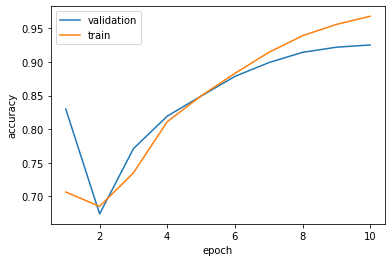

#units: 16
#batch_size: 128
#val_acc: 0.8926644325256348


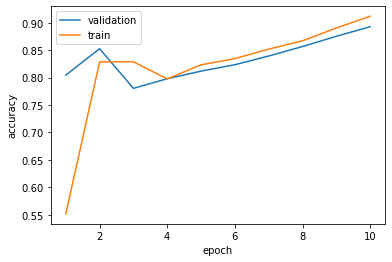

#units: 32
#batch_size: 64
#val_acc: 0.9388243556022644


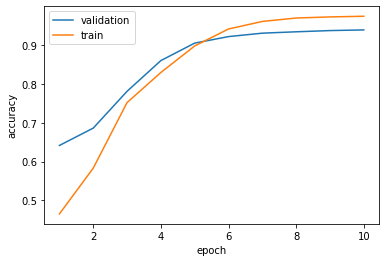

#units: 32
#batch_size: 128
#val_acc: 0.9282424449920654


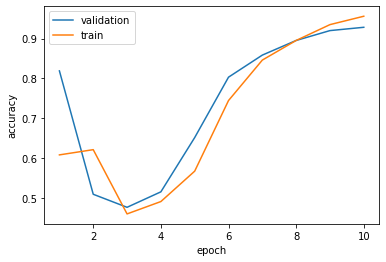

#units: 64
#batch_size: 64
#val_acc: 0.9416213035583496


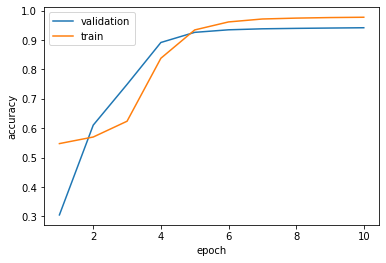

#units: 64
#batch_size: 128
#val_acc: 0.9321743249893188


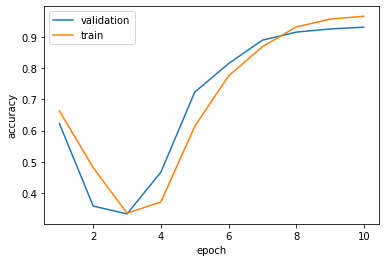

best params: {'unit': 64, 'batch_size': 64}


In [393]:
pos_tagger = PosTagger('GRU')
pos_tagger.search_best_model(params)

In [394]:
pos_tagger = PosTagger('GRU')
model,_,_ = pos_tagger.create_model(units = 64,batch_len=64, model_sum = True,verbose=1)
pos_tagger.eval_model(model)

Model: "sequential_253"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_252 (Embedding)   (None, 100, 150)          1500000   
                                                                 
 gru_47 (GRU)                (None, 100, 64)           41472     
                                                                 
 time_distributed_252 (TimeD  (None, 100, 13)          845       
 istributed)                                                     
                                                                 
Total params: 1,542,317
Trainable params: 1,542,317
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
45/45 [==============================] - 7s 115ms/step - loss: 1.2467 - ignore_accuracy: 0.7488 - val_loss: 0.6325 - val_ignore_accuracy: 0.5492
Epoch 2/10
45/45 [==============================] - 5s 102ms/step - loss: 0.555

# NER

In [280]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.chunk import tree2conlltags

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/mac/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/mac/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [330]:
class ViterbiNER:
    def __init__(self):
        self.data = nltk.corpus.treebank.tagged_sents()
        self.data = [tree2conlltags(nltk.ne_chunk(sent)) for sent in self.data]
        self.split_data()
        self.tags = list(set([word[1] for sent in self.train_set for word in sent]))
        self.vocab = list(set([word[0] for sent in self.train_set for word in sent]))
        self.words_tag = [(pair[0],pair[1]) for sent in self.train_set for pair in sent]
        self.tag_counts = self.get_tags_count()
        self.vocab_size = len(self.vocab)
        self.tag_size = len(self.tags)
        
    def split_data(self):
        self.train_set,self.test_set = train_test_split(self.data,test_size=0.15, random_state = 42)
        self.train_set = [[(word[0],word[2]) for word in sent] for sent in self.train_set]
        self.test_set = [[(word[0],word[2]) for word in sent] for sent in self.test_set]
        return self.train_set,self.test_set

    def get_emission_probability(self,word,tag):
        count_word_tag = sum([1 for pair in self.words_tag if (pair[0]==word and pair[1]==tag)])
        count_tag = self.tag_counts[tag]
        emission_probability = (count_word_tag+1)/(count_tag+self.vocab_size)
        return emission_probability

    def get_tags_count(self):
        self.tags_count = {}
        for tag in self.tags:
            self.tags_count[tag] = sum([1 for pair in self.words_tag if pair[1]==tag])
        return self.tags_count

    def get_word_tag_count(self):
        word_tag_count = {}
        for word in self.vocab:
            word_tag_count[word] = {tag: 0 for tag in self.tags}

        for pair in self.words_tag:
            word = pair[0]
            tag = pair[1]
            word_tag_count[word][tag] +=1
        return word_tag_count


    def set_emission_table(self):
        word_tag_count = self.get_word_tag_count()
        tag_counts = self.get_tags_count()
        emission = np.zeros((self.vocab_size,self.tag_size))
        for i in tqdm(range(len(self.vocab))):
            word = self.vocab[i]
            for j,tag in enumerate(self.tags):
                emission[i][j] = (word_tag_count[word][tag]+1)/(tag_counts[tag]+self.vocab_size)
        self.emission_df = pd.DataFrame(emission, columns = self.tags , index= self.vocab)


    def set_transition_table(self):
        tag_size = len(self.tags)
        transition = np.zeros((tag_size+1,tag_size))
        for i,tag1 in enumerate(self.tags):
            for j,tag2 in enumerate(self.tags):
                count_tag1 = sum([1 for pair in  self.words_tag if pair[1]==tag1])
                count_tag1_tag2 = sum([1 for idx in range(len(self.words_tag)-1) if (self.words_tag[idx][1]==tag1 and  self.words_tag[idx+1][1]==tag2)])
                transition[i][j] = (count_tag1_tag2+1)/(count_tag1+tag_size)

        start_tags = [sent[0][1] for sent in self.train_set]
        for k,tag2 in enumerate(self.tags):
            count_start = len(start_tags)
            count_start_tag2 = sum([1 for tag in start_tags if tag == tag2])
            transition[tag_size][k] = (count_start_tag2+1) / (count_start+tag_size)

        self.transition_df = pd.DataFrame(transition, columns = self.tags , index= self.tags+['<s>'])

        row_tag = self.transition_df.index
        row_tag = list(row_tag)
        for tag1 in row_tag:
            for tag2 in self.tags:
                if((tag1=='O' and tag2[:2]=='I-')) :
                      self.transition_df.loc[tag1,tag2] = 0
                if(tag1[:2]=='I-' and tag2[:2]=='I-' and tag1[2:]!=tag2[2:]):
                      self.transition_df.loc[tag1,tag2] = 0
                if(tag1[:2]=='B-' and tag2[:2]=='I-' and tag1[2:]!=tag2[2:]):
                    self.transition_df.loc[tag1,tag2] = 0
        return self.transition_df

    def get_tags(self,words):
        prev_step = {tag:{'prob': 0, 'steps':[]} for tag in self.tags}
        curr_step = {tag:{'prob': 0, 'steps':[]} for tag in self.tags}
        for i in range(len(words)):
            word = words[i]
            for tag in self.tags:
                if(word in self.vocab):
                    p_emission = self.emission_df.loc[word,tag]
                else:
                    p_emission = 1 /(self.tag_counts[tag]+self.vocab_size)

                if(i == 0):
                    p_transition = self.transition_df.loc['<s>',tag]
                    curr_step[tag]['prob'] = p_emission*p_transition
                    curr_step[tag]['steps'] = [tag]
                else:
                    probs = []
                    for prev_tag in self.tags:
                        p_transition = self.transition_df.loc[prev_tag,tag]
                        prev_tag_prob = prev_step[prev_tag]['prob']
                        prob = p_transition*prev_tag_prob*p_emission
                        probs.append(prob)
                        
                    pmax = max(probs)
                    chosen_tag = self.tags[probs.index(pmax)] 
                    curr_step[tag]['prob'] = pmax
                    curr_step[tag]['steps'] = prev_step[chosen_tag]['steps'] + [tag]
            prev_step = curr_step
            curr_step = {tag:{'prob': 0, 'steps':[]} for tag in self.tags}
            
     
        pmax = None
        for tag in self.tags:
            if(pmax == None):
                pmax = prev_step[tag]['prob']
                steps = prev_step[tag]['steps']
            elif(pmax < prev_step[tag]['prob']):
                pmax = prev_step[tag]['prob']
                steps = prev_step[tag]['steps']
    
        return list(zip(words, steps))

    def eval_model(self):
        corr_ans = 0 
        total = 0
        self.set_transition_table()
        self.set_emission_table()
        real =[]
        pred = []
        for i in tqdm(range(len(self.test_set))):
            sent = self.test_set[i]
            sent_word = [pair[0] for pair in sent]
            y_real = [pair[1] for pair in sent]
            y_pred = [pair[1] for pair in self.get_tags(sent_word)]
            real += y_real
            pred += y_pred
            corr_ans += sum([1 for i, j in zip(y_pred,y_real) if i == j])
            total += len(sent)
        print(classification_report(real, pred))
        accuracy = corr_ans/total
        print("accuracy: ",accuracy)
    
    def print_wrong_tags(self,num):
        test = self.test_set[:num]
        for i in range(len(test)):
            sent = test[i]
            sent_word = [pair[0] for pair in sent]
            real = [pair[1] for pair in sent]
            pred = [pair[1] for pair in self.get_tags(sent_word)]
            wrong_real = [real[i] for i in range(len(real)) if real[i]!=pred[i]]
            wrong_pred = [pred[i] for i in range(len(real)) if real[i]!=pred[i]]
            wrong_word = [sent_word[i] for i in range(len(real)) if real[i]!=pred[i]]
            if(real!=pred):
                print('sent',' '.join(sent_word))
                print('w_word',wrong_word)
                print('w_real',wrong_real)
                print('w_pred',wrong_pred)
                print('-----------------------------------------------')

In [331]:
viterbi = ViterbiNER()
viterbi.eval_model()

100%|██████████| 588/588 [01:12<00:00,  8.09it/s]
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

    B-FACILITY       1.00      0.70      0.82        10
         B-GPE       0.91      0.54      0.68       289
         B-GSP       0.00      0.00      0.00         6
    B-LOCATION       0.00      0.00      0.00         7
B-ORGANIZATION       0.78      0.39      0.52       228
      B-PERSON       0.77      0.49      0.60       299
    I-FACILITY       1.00      0.58      0.74        12
         I-GPE       0.75      0.82      0.79        40
         I-GSP       0.00      0.00      0.00         1
    I-LOCATION       0.00      0.00      0.00         8
I-ORGANIZATION       0.66      0.64      0.65       151
      I-PERSON       0.54      0.71      0.61       173
             O       0.97      0.99      0.98     14220

      accuracy                           0.96     15444
     macro avg       0.57      0.45      0.49     15444
  weighted avg       0.95      0.96      0.95     15444

accuracy:  0.9573297073297073


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
